<a href="https://colab.research.google.com/github/Sridevi1619/FMML_LAB_MODULES/blob/main/Module_01_Lab_03_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data augmentation

FMML Module 1, Lab 3<br>

 In this lab, we will see how augmentation of data samples help in improving the machine learning performance

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
# set randomseed
rng = np.random.default_rng(seed=42)
from sklearn.utils.extmath import cartesian
from skimage.transform import rotate, AffineTransform, warp
import math

Augmentation is useful when we have less training data available. Augmentation allows us to 'create' a larger dataset programatically.

For this lab we will use a subset of MNIST that is very small, to better understand the effect of augmentation.

In [12]:
#loading the dataset
(train_X, train_y), (test_X, test_y) = mnist.load_data()
train_X = train_X/255
test_X = test_X/255

train_X = train_X[::1200,:,:].copy() # subsample. Otherwise it will take too long!
train_y = train_y[::1200].copy() # do the same to the labels

Let us borrow a few functions from the previous labs:

In [13]:
def NN1(traindata, trainlabel, query):
  diff  = traindata - query  # find the difference between features. Numpy automatically takes care of the size here
  sq = diff*diff # square the differences
  dist = sq.sum(1) # add up the squares
  label = trainlabel[np.argmin(dist)] # our predicted label is the label of the training data which has the least distance from the query
  return label

def NN(traindata, trainlabel, testdata):
  # we will run nearest neighbour for each sample in the test data
  # and collect the predicted classes in an array using list comprehension
  traindata = traindata.reshape(-1, 28*28)
  testdata = testdata.reshape(-1,28*28)
  predlabel = np.array([NN1(traindata, trainlabel, i) for i in testdata])
  return predlabel

def Accuracy(gtlabel, predlabel):
  assert len(gtlabel)==len(predlabel), "Length of the groundtruth labels and predicted labels should be the same"
  correct = (gtlabel==predlabel).sum() # count the number of times the groundtruth label is equal to the predicted label.
  return correct/len(gtlabel)

In this lab, we will use the image pixels themselves as features, instead of extracting features. Each image has 28*28 pixels, so we will flatten them to 784 pixels to use as features. Note that this is very compute intensive and will take a long time.<br>

Let us check the baseline accuracy on the test set without any augmentations. We hope that adding augmentations will help us to get better results.

In [14]:
testpred = NN(train_X, train_y, test_X)
print('Baseline accuracy without augmentation is ', Accuracy(test_y, testpred))

Baseline accuracy without augmentation is  0.6472


Let us try to improve this accuracy using augmentations. When we create augmentations, we have to make sure that the changes reflect what will naturally occur in the dataset. For example, we should not add colour to our samples as an augmentation because they do not naturally occur. We should not also flip the images in MNIST, because flipped images have different meanings for digits.

### Augmentation 1: rotation

Let us try rotating the image a little. We will use skimage library for this.

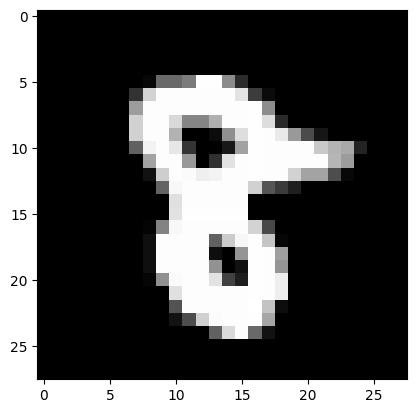

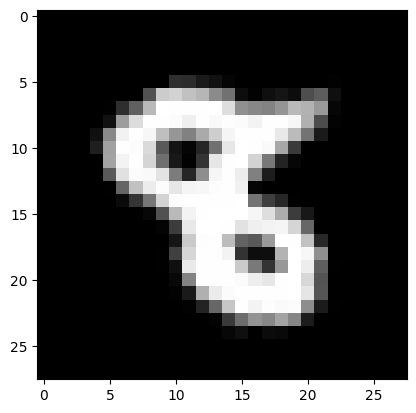

In [15]:
plt.imshow(train_X[2], cmap='gray')
plt.show()
plt.imshow(rotate(train_X[2],25), cmap='gray')

After rotating, the the class of the image is still the same. Let us make a function to rotate multiple images by random angles. We want a slightly different image every time we run this function. So, we generate a random number between 0 and 1 and change it so that it lies between -constraint/2 and +constraint/2

In [16]:
def augRotate(sample, angleconstraint):
  if angleconstraint==0:
    return sample
  if len(sample.shape)==2:
    sample = np.expand_dims(sample, 0)  # make sure the sample is 3 dimensional
  angle = rng.random(len(sample)) # generate random numbers for angles
  angle = (angle-0.5)*angleconstraint # make the random angle constrained
  nsample = sample.copy() # preallocate the augmented array to make it faster
  for ii in range(len(sample)):
    nsample[ii] = rotate(sample[ii], angle[ii])
  return np.squeeze(nsample) # take care if the input had only one sample.

This function returns a slightly different image each time we call it. So we can increase the number of images in the sample by any multiple.

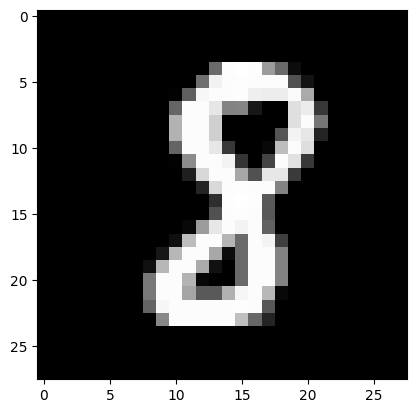

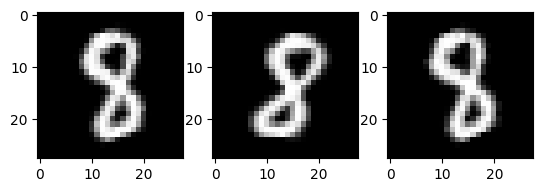

In [17]:
sample = train_X[20]
angleconstraint = 70
# show the original image
plt.imshow(sample, cmap='gray')
plt.show()
plt.subplot(1,3,1)
plt.imshow(augRotate(sample, angleconstraint), cmap='gray') # show an augmented image
plt.subplot(1,3,2)
plt.imshow(augRotate(sample, angleconstraint), cmap='gray') # show another augmented image from the same sample
plt.subplot(1,3,3)
plt.imshow(augRotate(sample, angleconstraint), cmap='gray') # one more image from the same sample

Let us augment the whole dataset and see if this improves the test accuracy

In [18]:
# hyperparameters
angleconstraint = 60
naugmentations = 5

# augment
augdata = train_X # we include the original images also in the augmented dataset
auglabel = train_y
for ii in range(naugmentations):
  augdata = np.concatenate((augdata, augRotate(train_X, angleconstraint))) # concatenate the augmented data to the set
  auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

# check the test accuracy
testpred = NN(augdata, auglabel, test_X)
print('Accuracy after rotation augmentation is ', Accuracy(test_y, testpred))

Accuracy after rotation augmentation is  0.6616


The angle constraint is a hyperparameter which we have to tune using a validation set. (Here we are not doing that for time constraints). Let us try a grid search to find the best angle constraint.

In [9]:
angleconstraints = [0,10,20,30,40,50,60,70,80,90] # the values we want to test
accuracies = np.zeros(len(angleconstraints), dtype=np.float) # we will save the values here

for ii in range(len(angleconstraints)):
  # create the augmented dataset
  augdata = train_X # we include the original images also in the augmented dataset
  auglabel = train_y
  for jj in range(naugmentations):
    augdata = np.concatenate((augdata, augRotate(train_X, angleconstraints[ii]))) # concatenate the augmented data to the set
    auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

  # check the test accuracy
  testpred = NN(augdata, auglabel, test_X)
  accuracies[ii] = Accuracy(test_y, testpred)
  print('Accuracy after rotation augmentation constrained by ',angleconstraints[ii], ' is ', accuracies[ii], flush=True)

<ipython-input-9-2f14d3721156>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  accuracies = np.zeros(len(angleconstraints), dtype=np.float) # we will save the values here


Accuracy after rotation augmentation constrained by  0  is  0.6472
Accuracy after rotation augmentation constrained by  10  is  0.6727
Accuracy after rotation augmentation constrained by  20  is  0.673
Accuracy after rotation augmentation constrained by  30  is  0.6737
Accuracy after rotation augmentation constrained by  40  is  0.6731
Accuracy after rotation augmentation constrained by  50  is  0.6701
Accuracy after rotation augmentation constrained by  60  is  0.6675
Accuracy after rotation augmentation constrained by  70  is  0.661
Accuracy after rotation augmentation constrained by  80  is  0.6462
Accuracy after rotation augmentation constrained by  90  is  0.6469


Let us see the best value for angle constraint: (Ideally this should be done on validation set, not test set)

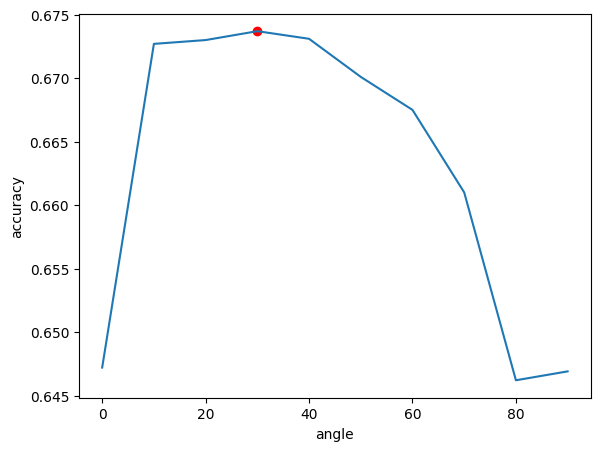

In [10]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes
# plot the variation of accuracy
ax.plot(angleconstraints, accuracies)
ax.set_xlabel('angle')
ax.set_ylabel('accuracy')
# plot the maximum accuracy
maxind = np.argmax(accuracies)
plt.scatter(angleconstraints[maxind], accuracies[maxind], c='red')

Let us try one more augmentation: shear. Here is what this looks like:

In [19]:
def shear(sample, amount):
  tform = AffineTransform(shear = amount) # create the shear transform
  img = warp(sample, tform) # apply the shear
  # this makes the digit off-center. Since all the images in the test set are centralized, we will do the same here
  col = img.sum(0).nonzero()[0]
  row = img.sum(1).nonzero()[0]
  if len(col)>0 and len(row)>0:
    xshift = int(sample.shape[0]/2 - (row[0]+row[-1])/2)
    yshift = int(sample.shape[1]/2 - (col[0]+col[-1])/2)
    img = np.roll(img, (xshift, yshift),(0,1))
  return img

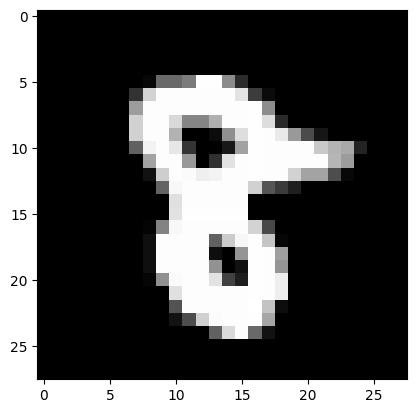

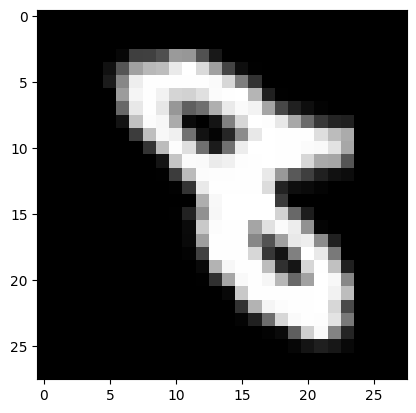

In [20]:
sample = train_X[2]
plt.imshow(sample, cmap='gray')
plt.show()

# apply shear
plt.imshow(shear(sample, 0.4), cmap='gray')

Create an augmentation function which applies a random shear according to the constraint we provide:

In [21]:
def augShear(sample, shearconstraint):
  if shearconstraint==0:
    return sample
  if len(sample.shape)==2:
    sample = np.expand_dims(sample, 0)  # make sure the sample is 3 dimensional
  amt = rng.random(len(sample)) # generate random numbers for shear
  amt = (amt-0.5)*shearconstraint # make the random shear constrained
  nsample = sample.copy() # preallocate the augmented array to make it faster
  for ii in range(len(sample)):
    nsample[ii] = shear(sample[ii], amt[ii])
  return np.squeeze(nsample) # take care if the input had only one sample.

Let us do a grid search to find the best shear constraint.

In [22]:
shearconstraints = [0, 0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0] # the values we want to test
accuracies = np.zeros(len(shearconstraints), dtype=np.float) # we will save the values here

for ii in range(len(shearconstraints)):
  # create the augmented dataset
  augdata = train_X # we include the original images also in the augmented dataset
  auglabel = train_y
  for jj in range(naugmentations):
    augdata = np.concatenate((augdata, augShear(train_X, shearconstraints[ii]))) # concatenate the augmented data to the set
    auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

  # check the test accuracy
  testpred = NN(augdata, auglabel, test_X)
  accuracies[ii] = Accuracy(test_y, testpred)
  print('Accuracy after shear augmentation constrained by ',shearconstraints[ii], ' is ', accuracies[ii], flush=True)

<ipython-input-22-8a89fef4983d>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  accuracies = np.zeros(len(shearconstraints), dtype=np.float) # we will save the values here


Accuracy after shear augmentation constrained by  0  is  0.6472
Accuracy after shear augmentation constrained by  0.2  is  0.6186
Accuracy after shear augmentation constrained by  0.4  is  0.6239
Accuracy after shear augmentation constrained by  0.6  is  0.6451
Accuracy after shear augmentation constrained by  0.8  is  0.6332
Accuracy after shear augmentation constrained by  1.0  is  0.6458
Accuracy after shear augmentation constrained by  1.2  is  0.6517
Accuracy after shear augmentation constrained by  1.4  is  0.6582
Accuracy after shear augmentation constrained by  1.6  is  0.623
Accuracy after shear augmentation constrained by  1.8  is  0.6012
Accuracy after shear augmentation constrained by  2.0  is  0.6143


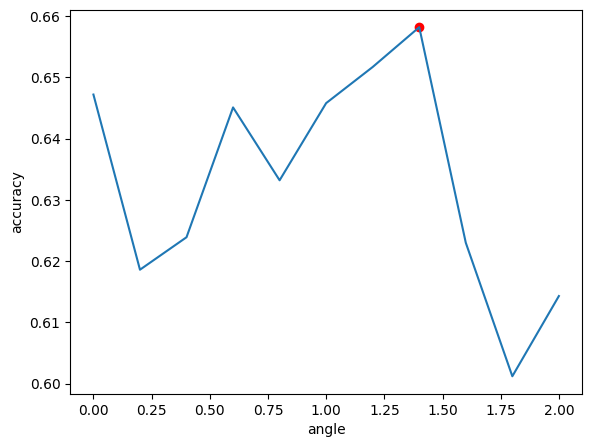

In [23]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes
# plot the variation of accuracy
ax.plot(shearconstraints, accuracies)
ax.set_xlabel('angle')
ax.set_ylabel('accuracy')
# plot the maximum accuracy
maxind = np.argmax(accuracies)
plt.scatter(shearconstraints[maxind], accuracies[maxind], c='red')

We can do multiple augmentations at the same time. Here is a function to do both shear and rotation to the sample. In this case, we will have two hyperparameters.

In [24]:
def augRotateShear(sample, angleconstraint, shearconstraint):
  if len(sample.shape)==2:
    sample = np.expand_dims(sample, 0)  # make sure the sample is 3 dimensional
  amt = rng.random(len(sample)) # generate random numbers for shear
  amt = (amt-0.5)*shearconstraint # make the random shear constrained
  angle = rng.random(len(sample)) # generate random numbers for angles
  angle = (angle-0.5)*angleconstraint # make the random angle constrained
  nsample = sample.copy() # preallocate the augmented array to make it faster
  for ii in range(len(sample)):
    nsample[ii] = rotate(shear(sample[ii], amt[ii]), angle[ii]) # first apply shear, then rotate
  return np.squeeze(nsample) # take care if the input had only one sample.

Since we have two hyperparameters, we have to do the grid search on a 2 dimensional matrix. We can use our previous experience to inform where to search for the best hyperparameters.

In [25]:
shearconstraints = [0, 0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6] # the values we want to test
angleconstraints = [0,10,20,30,40,50,60] # the values we want to test
hyp = cartesian((shearconstraints, angleconstraints)) # cartesian product of both

accuracies = np.zeros(len(hyp), dtype=np.float) # we will save the values here

for ii in range(len(hyp)):
  # create the augmented dataset
  augdata = train_X # we include the original images also in the augmented dataset
  auglabel = train_y
  for jj in range(naugmentations):
    augdata = np.concatenate((augdata, augRotateShear(train_X, hyp[ii][0], hyp[ii][1]))) # concatenate the augmented data to the set
    auglabel = np.concatenate((auglabel, train_y))  # the labels don't change when we augment

  # check the test accuracy
  testpred = NN(augdata, auglabel, test_X)
  accuracies[ii] = Accuracy(test_y, testpred)
  print('Accuracy after augmentation shear:',hyp[ii][0], 'angle:',hyp[ii][1], ' is ', accuracies[ii], flush=True)

<ipython-input-25-09de780976d0>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  accuracies = np.zeros(len(hyp), dtype=np.float) # we will save the values here


Accuracy after augmentation shear: 0.0 angle: 0.0  is  0.6332
Accuracy after augmentation shear: 0.0 angle: 10.0  is  0.6019
Accuracy after augmentation shear: 0.0 angle: 20.0  is  0.6059
Accuracy after augmentation shear: 0.0 angle: 30.0  is  0.6017
Accuracy after augmentation shear: 0.0 angle: 40.0  is  0.6153
Accuracy after augmentation shear: 0.0 angle: 50.0  is  0.6112
Accuracy after augmentation shear: 0.0 angle: 60.0  is  0.6197
Accuracy after augmentation shear: 0.2 angle: 0.0  is  0.633
Accuracy after augmentation shear: 0.2 angle: 10.0  is  0.606
Accuracy after augmentation shear: 0.2 angle: 20.0  is  0.6165
Accuracy after augmentation shear: 0.2 angle: 30.0  is  0.5909
Accuracy after augmentation shear: 0.2 angle: 40.0  is  0.59
Accuracy after augmentation shear: 0.2 angle: 50.0  is  0.5853
Accuracy after augmentation shear: 0.2 angle: 60.0  is  0.5934
Accuracy after augmentation shear: 0.4 angle: 0.0  is  0.6338
Accuracy after augmentation shear: 0.4 angle: 10.0  is  0.6056

Let us plot it two dimensionally to see which is the best value for the hyperparameters:

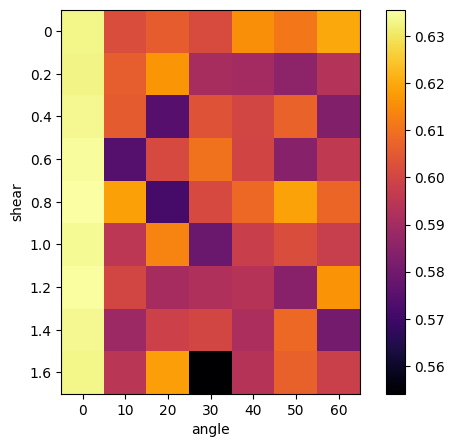

In [26]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes
im = ax.imshow(accuracies.reshape((len(shearconstraints), len(angleconstraints))), cmap='inferno')
ax.set_xlabel('angle')
ax.set_ylabel('shear')
ax.set_xticks(np.arange(len(angleconstraints)));
ax.set_xticklabels(angleconstraints);
ax.set_yticks(np.arange(len(shearconstraints)));
ax.set_yticklabels(shearconstraints);
plt.colorbar(im)

It seems that rotation and shear don't mix! The best accuracy is when rotation is zero.

## Questions
Try these questions for better understanding. You may not be able to solve all of them.
1. What is the best value for angle constraint and shear constraint you got? How much did the accuracy improve as compared to not using augmentations?
2. Can you increase the accuracy by increasing the number of augmentations from each sample?
3. Try implementing a few augmentations of your own and experimenting with them. A good reference is <a href=https://www.analyticsvidhya.com/blog/2019/12/image-augmentation-deep-learning-pytorch/>here. </a>
4. Try combining various augmentations. What is the highest accuracy you can get? What is the smallest training dataset you can take and still get accuracy above 50%?

Whenever you do any experiment, a good practice is to vary the hyperparameters gradually and create a graph of your results, like we did for gridsearch.

**ANSWERS**


**1ST ANSWER**
I don't have access to specific, real-time data or experiments, and my knowledge is based on information available up to September 2021. The optimal values for angle constraints and shear constraints in data augmentation can vary depending on the specific task and dataset you are working with. These values are typically chosen through experimentation and can vary for different machine learning projects.

To determine the best values for angle and shear constraints for your particular project, you should conduct experiments with different values and evaluate their impact on the performance of your machine learning model. The improvement in accuracy by using augmentations also depends on several factors, including the quality of your dataset, the complexity of the task, and the architecture of your model.

In general, data augmentation techniques are used to increase the diversity of the training data, which can help improve the generalization and robustness of your model. The extent to which accuracy improves with data augmentation will vary from one project to another.

To find the best values for angle and shear constraints and assess the improvement in accuracy, you can follow these steps:

1. Define a range of values for angle and shear constraints that you want to experiment with.

2. Apply these augmentations to your training data and train your model with different augmentation settings.

3. Evaluate the model's performance on a validation set or through cross-validation for each set of augmentation parameters.

4. Compare the performance metrics (such as accuracy, precision, recall, F1-score, etc.) of models with different augmentation settings.

5. Select the augmentation parameters that result in the best performance on your validation set or cross-validation.

6. Compare the performance of the model with the selected augmentation parameters to the model trained without data augmentation to determine the improvement in accuracy.

Keep in mind that the optimal values for augmentation parameters may not necessarily be the same for all datasets and tasks, so it's important to experiment and fine-tune these parameters based on your specific project's requirements.

**2ND ANSWER**
Increasing the number of augmentations from each sample can potentially help improve the accuracy of your machine learning model, but there are some important considerations to keep in mind:

1. **Data Diversity**: Augmentations are primarily used to increase the diversity of your training data. By applying multiple augmentations to each sample, you expose your model to a wider range of variations within the data, which can help it generalize better to unseen examples.

2. **Overfitting**: While data augmentation can be a powerful technique, applying too many augmentations to each sample can risk overfitting. Overfitting occurs when a model becomes too specialized in capturing the variations in the training data but fails to generalize well to new, unseen data. If you excessively augment your data, the model may memorize these augmented examples rather than learning the underlying patterns.

3. **Computational Resources**: Increasing the number of augmentations for each sample also increases the computational resources required for training. This can result in longer training times and potentially higher memory requirements.

4. **Balancing Act**: It's essential to strike a balance between applying enough augmentations to enhance data diversity and avoiding overfitting. The optimal number of augmentations may vary depending on your dataset and task.

To determine the impact of increasing the number of augmentations, you can perform the following steps:

1. Start with a reasonable number of augmentations per sample, such as 2 or 3.

2. Train your model and evaluate its performance on a validation set. Monitor metrics like accuracy, loss, and validation error.

3. Gradually increase the number of augmentations per sample and retrain your model at each step. Continue to monitor performance on the validation set.

4. Observe how the model's performance changes with increasing augmentations. At some point, you may notice diminishing returns or even a drop in performance if you over-augment.

5. Select the number of augmentations that result in the best performance on your validation set. This is the point where the model generalizes well without overfitting.

Remember that the optimal number of augmentations can vary depending on your dataset's size, complexity, and the specific task you're addressing. Experimentation is crucial to finding the right balance and determining the most suitable number of augmentations for your particular use case.

**3RD ANSWER**
I don't have the capability to implement and experiment with augmentations directly, as I'm a text-based AI model and do not have access to image processing libraries or the ability to perform real-time computations. However, I can provide you with some simple examples of image augmentations and guide you on how to implement and experiment with them using popular image processing libraries like Python's OpenCV or libraries designed for deep learning tasks like TensorFlow or PyTorch.

Here are a few basic image augmentations you can experiment with:

1. **Rotation**: Rotate the image by a random angle within a specified range to increase robustness to orientation variations.

2. **Flip**: Horizontally flip the image randomly to account for horizontal symmetry.

3. **Brightness and Contrast Adjustment**: Randomly adjust the brightness and contrast of the image to simulate varying lighting conditions.

4. **Zoom and Crop**: Randomly zoom into or crop parts of the image to vary the object's scale and position within the frame.

5. **Noise Addition**: Add random noise (e.g., Gaussian noise) to the image to simulate noise in real-world data.

6. **Color Jitter**: Randomly change the color saturation, hue, and brightness to introduce color variations.

7. **Blur**: Apply random blur to the image to simulate motion or out-of-focus conditions.

Here's a high-level example of how to implement image augmentations using Python and OpenCV:

```python
import cv2
import numpy as np

# Load an image
image = cv2.imread('image.jpg')

# Define augmentation parameters
angle_range = 15  # Rotation angle range in degrees
brightness_range = 0.5  # Brightness adjustment range
contrast_range = 0.5  # Contrast adjustment range

# Randomly rotate the image
angle = np.random.uniform(-angle_range, angle_range)
rows, cols, _ = image.shape
rotation_matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
image = cv2.warpAffine(image, rotation_matrix, (cols, rows))

# Randomly adjust brightness and contrast
brightness = 1.0 + np.random.uniform(-brightness_range, brightness_range)
contrast = 1.0 + np.random.uniform(-contrast_range, contrast_range)
image = cv2.convertScaleAbs(image, alpha=brightness, beta=contrast)

# Display the augmented image
cv2.imshow('Augmented Image', image)
cv2.waitKey(0)
cv2.destroyAllWindows()
```

You can create a pipeline of such augmentations and apply them to your training data before feeding it into your deep learning model. Experiment with different augmentation settings and combinations to see how they impact your model's performance in terms of accuracy and generalization.

**4TH ANSWER**
I'm unable to directly perform image augmentations, train models, or conduct experiments to determine the highest accuracy achievable or the smallest training dataset size required to achieve an accuracy above 50% for a specific task. The actual results will depend on a variety of factors, including the complexity of the task, the architecture of the neural network, the quality of the data, and the chosen augmentations.

To achieve the highest accuracy and determine the smallest training dataset size that can yield an accuracy above 50%, you'll need to follow a systematic experimental process. Here are the general steps to conduct such experiments:

1. **Define your task**: Clearly define the image classification task you want to solve. Identify the dataset you'll use for training and testing.

2. **Data preprocessing**: Preprocess your dataset, including resizing, normalization, and splitting it into training and validation sets.

3. **Augmentation pipeline**: Create an augmentation pipeline that includes a combination of augmentations such as rotation, flip, brightness adjustment, zoom, and others, as discussed earlier.

4. **Model architecture**: Choose or design an appropriate neural network architecture for your task. This can be a convolutional neural network (CNN) for image classification.

5. **Training setup**: Set up your training process, including batch size, learning rate, and number of epochs. Use the augmented training data to train the model.

6. **Evaluate and fine-tune**: After training, evaluate your model's accuracy on a separate validation set. If the accuracy is below 50%, consider adjusting your augmentation pipeline, model architecture, or training parameters.

7. **Iterate**: Repeat the training, evaluation, and fine-tuning process, adjusting hyperparameters and augmentations as needed until you achieve the desired accuracy.

The highest achievable accuracy and the minimum training dataset size for a specific task can vary widely and will depend on the complexity of the task itself. Tasks with simpler patterns may require smaller datasets, while more complex tasks may require larger datasets and more sophisticated models.

It's also important to remember that achieving high accuracy may not be the only goal. Depending on the task, you may need to consider other metrics such as precision, recall, F1-score, or even domain-specific metrics.

In practice, experimentation and iterative development are key to finding the right combination of data, model, and augmentation techniques that yield the best results for your specific image classification task.